# <span style="color:darkslateblue"> Meccanica Statistica 1 </span>
## <span style="color:darkcyan">  Exercise 4 on the Ising Model. Samuele Voltan's notebook.</span>

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython import display
from collections import Counter
from scipy.optimize import curve_fit
import sys
sys.path.append("code/")
sys.setrecursionlimit(10**5)
from my_ising import myIsing
from ising_sethna import IsingModel
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

## <span style="color:darkslateblue">The Ising model in 2D </span>
The Hamiltonian of the Ising model is

$$
\mathcal{H} = -\sum_{\langle ij \rangle} J s_i s_j - H \sum_i s_i
$$

where the sum $\langle ij \rangle$ runs over neighbouring sites only. In our 2D lattice, each site has 4 neighbours (and we will work in periodic boundary conditions). We focus on the case $J=1, H=0$, that is, a ferromagnetic system with no external field. 

In order to simplify the structure of the notebook, I implemented my functions in a class `myIsing`.

### <span style="color:darkcyan">Exercice 4.1
Write a function that, given an integer $N$, returns an $N \times N$ array whose elements are randomly picked from {-1, 1}. 
    
This is done by the constructor in `myIsing`. Below I show the system using `plt.imshow()`.

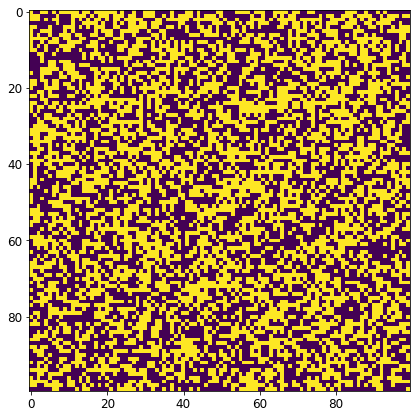

In [2]:
model = myIsing(N=100)
plt.figure(figsize = (7, 7))
plt.imshow(model.lattice)

### <span style="color:darkcyan">Exercise 4.2
Given a site $(i, j)$, the change in energy $\Delta E$ that flipping $S(i, j)$ entails is
 
$$
\Delta E = -2 S(i, j)\left[S(i+1, j)+S(i-1, j)+S(i, j+1)+S(i, j-1)\right]
$$

### <span style="color:darkcyan">Exercise 4.3
I define a method `myIsing::Metropolis` implemented in `my_ising.py`. A single update of the Metropolis algorithm works as follows:

1. Pick a site $(i, j)$ at random.
2. Calculate the energy change $\Delta E$ that flipping the spin $s_{ij}$ would produce.
3. If $\Delta E <0$, flip the spin with probability $1$.
4. If $\Delta E >0$, flip the spin with probability $e^{-\beta \Delta E}$.

### <span style="color:darkcyan">Exercice 4.4
I define a method that computes the energy of a configuration: `myIsing::GetEnergy` implemented in `my_ising.py`, and another that tracks its evolution over time that's implemented below. Note that I don't need to calculate the energy of the whole spin configuration each time, since `myIsing::Metropolis` returns the actual energy difference from step to step. Therefore, I can increase the performance by writing `energy += model.Metropolis()` insted of `model.GetEnergy()`. This cannot be used when dealing with Sethna's implementation, therefore I will define another function later that computes the energy each time.

In [3]:
def myEnergyEvolution(model, n_updates):
    energy = model.GetEnergy() # initial energy
    energy_list = [energy]
    for i in range(n_updates):
        energy += model.Metropolis()
        
        ####### NB: if we write every step, then the data files will be too heavy.
        ####### let's write only one over 50 steps
        if(i%50 == 0):
            energy_list += [energy]
    return np.asarray(energy_list) # return list as array

### <span style="color:darkcyan">Exercise 4.5
Here I show the energy evolution as a function of time (i.e. of each single Metropolis step) during a long ($N_\text{updates} = 10^7$) simulation.

In [4]:
# comment the following lines in order to avoid repeating the simulation
# current simulated data can be found in files data/ev_<T>.dat
"""
T_c = 2/np.log(1 + np.sqrt(2))
temps = [1.5, T_c, 3.5]
models = [myIsing(N=100, T=temp) for temp in temps]
energy_evolution = [myEnergyEvolution(model, 10**7) for model in models]

# the following lines save data, so that one need not do the simulation again
for temp, e in zip(temps, energy_evolution):
    np.savetxt('data/ev_' + str(temp) +'.dat', e)
"""

"\nT_c = 2/np.log(1 + np.sqrt(2))\ntemps = [1.5, T_c, 3.5]\nmodels = [myIsing(N=100, T=temp) for temp in temps]\nenergy_evolution = [myEnergyEvolution(model, 10**7) for model in models]\n\n# the following lines save data, so that one need not do the simulation again\nfor temp, e in zip(temps, energy_evolution):\n    np.savetxt('data/ev_' + str(temp) +'.dat', e)\n"

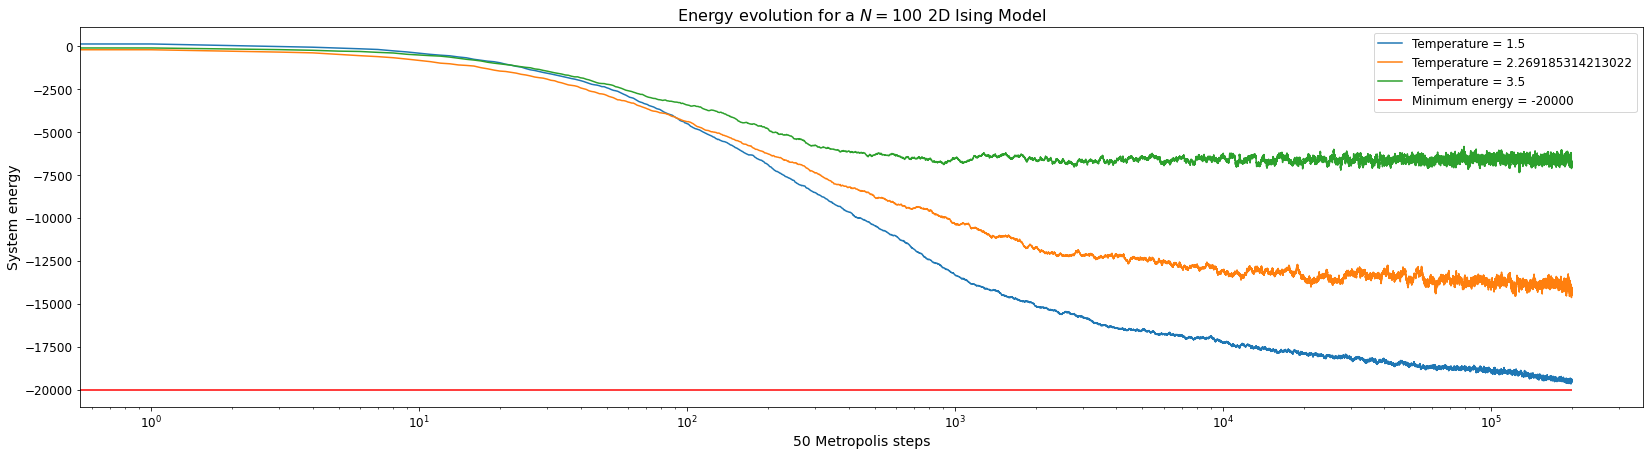

In [5]:
T_c = 2/np.log(1 + np.sqrt(2))
temps = [1.5, T_c, 3.5]
energy_evolution = [np.loadtxt('data/ev_' + str(temp) +'.dat') for temp in temps]
fig, ax = plt.subplots(1, 1, figsize = (28, 7))
ax.set_title('Energy evolution for a $N=100$ 2D Ising Model')
for e,t in zip(energy_evolution, temps):
    ax.semilogx(e, label='Temperature = ' + str(t))
ax.hlines(-20000, 0, len(e), label='Minimum energy = -20000', color='r')
ax.set_xlabel('50 Metropolis steps')
ax.set_ylabel('System energy')
ax.legend()

### <span style="color:darkcyan">Exercise 4.6
Can you distinguish two qualitatively different periods? What do they correspond to?

It is possible to distinguish two qualitatively different periods: firstly, the energy decreases as the system equilibrates, modifying its spin configuration. In the second period, the energy trend is more conservative as it fluctuates around a certain value depending on its temperature. Note that the behavior of the system at $T<T_c$ is tipically ferromagnetic: the energy is minimized by the fact that there is a spontaneous magnetization. In fact, the energy of the spin configuration is minimized

$$
E = -\sum_{\langle ij \rangle}^{N=100} s_i s_j = -20000 \iff s_i=s_j\quad\forall i,j=1,\dots,N=100
$$

as one can verify below.

In [6]:
x = myIsing(N=100)
for i in range(100):
    for j in range(100):
        x.lattice[i][j] = 1
print(x.GetEnergy())

-20000


Therefore, for $N_\text{updates}\to\infty$, all spins for $T<T_c$ will eventually become either $+1$ or $-1$. Note that $10^7$ updates are still not enough to see the ferromagnetic phase totally equilibrated.

### <span style="color:darkcyan">Exercice 4.7
I test the performance of Sethna's implementation compared to mine. The first difference of the two implementations is how they deal with time-steps: mine performs an update of the system for each time step, while the `IsingModel::SweepMetropolis` method performs $N^2$ updates per time-step, unless otherwise specified. Therefore, if one wants to compare the efficiency of the algorithms, one must call `myIsing::Metropolis` $N^2$ times in order to perform the same amount of operations that Sethna's method performs in only one call.

In [7]:
%%time
N = 100
nTimes = 10
myModel = myIsing(N)
for i in range(nTimes * N**2) :
    myModel.Metropolis()

CPU times: user 2.66 s, sys: 0 ns, total: 2.66 s
Wall time: 2.66 s


Here follows Sethna's implementation. Note that I slightly modified the constructor by including a variabile `N_eq=None` that, if specified, will thermalize the model at the moment of its instantiation, as follows:
```Python
if N_eq is None:
            if verbose is True:
                print('The model has not been thermalized yet.')
        else:
            self.Equilibrate(N_eq)
            if verbose is True:
                print('The model has been thermalized with ' + str(N_eq) + ' Wolff sweeps.')
```
Note that the keywork `verbose=True` has also been introduced in the constructor.

In [8]:
%%time
N = 100
sethna = IsingModel(N)
sethna.SweepMetropolis(nTimes=10)

The model has not been thermalized yet.
CPU times: user 339 ms, sys: 0 ns, total: 339 ms
Wall time: 337 ms


I can see that Sethna's implementation has very high performances compared to mine. The following lines are a test of the new constructor.

The model has been thermalized with 10 Wolff sweeps.
CPU times: user 410 ms, sys: 0 ns, total: 410 ms
Wall time: 409 ms


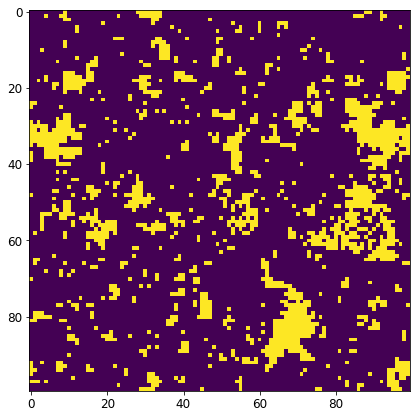

In [9]:
%%time
thermalized = IsingModel(N=100, N_eq=10)
plt.figure(figsize = (7, 7))
plt.imshow(thermalized.lattice)

As expected, building an already thermalized model is equivalent to building a non-thermalized one and perform the same amount of Wolff sweeps.
One also sees the result of the thermalization from the fact that the spins are heavily clustered.

### <span style="color:darkcyan">Exercise 4.8
I investigate how many sweeps of the Wolff algorithm are necessary to reach equilibrium for a system of size $N=100$. As observed above, I need to introduce a new function for the energy evolution, since Sethna's methods do not return the change in energy when performing a Metropolis or a Wolff update.

In [10]:
def EnergyEvolution(model, n_updates):
    energy_list = [model.GetEnergy()] # initial energy
    for i in range(n_updates) :
        model.SweepWolff()
        energy_list += [model.GetEnergy()]
    return np.asarray(energy_list) # return list as array

In order to perform the simulation, I added the method `IsingModel::GetEnergy` to Sethna's class, and a `IsingModel::GetLattice` method in order to have $\pm 1$ as the lattice spin values, instead of $0$ and $1$. Here follows the search for equlibrium.

In [11]:
# comment the following lines in order to avoid repeating the simulation
# current simulated data can be found in files data/sethna_ev_<T>.dat
"""
T_c = 2/np.log(1 + np.sqrt(2))
temps = [1.5, T_c, 3.5]
models = [IsingModel(N=100, T=temp) for temp in temps]
energy_evolution = [EnergyEvolution(model, 10**2) for model in models]

# the following lines save data, so that one need not do the simulation again
for temp, e in zip(temps, energy_evolution):
    np.savetxt('data/sethna_ev_' + str(temp) +'.dat', e)
"""

"\nT_c = 2/np.log(1 + np.sqrt(2))\ntemps = [1.5, T_c, 3.5]\nmodels = [IsingModel(N=100, T=temp) for temp in temps]\nenergy_evolution = [EnergyEvolution(model, 10**2) for model in models]\n\n# the following lines save data, so that one need not do the simulation again\nfor temp, e in zip(temps, energy_evolution):\n    np.savetxt('data/sethna_ev_' + str(temp) +'.dat', e)\n"

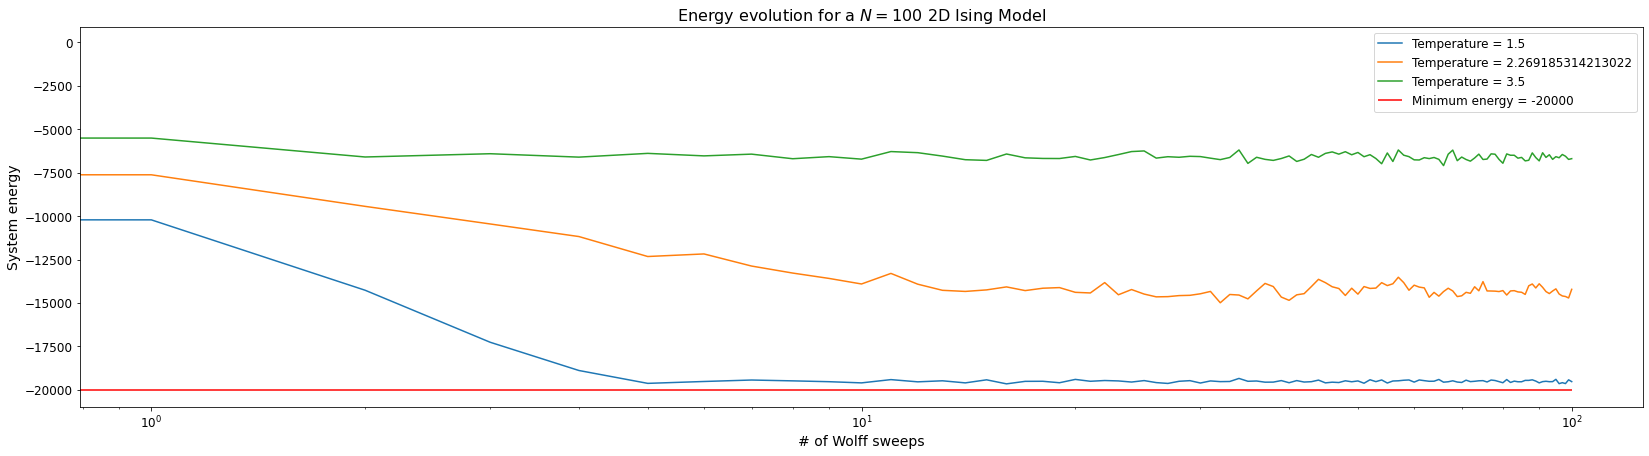

In [12]:
T_c = 2/np.log(1 + np.sqrt(2))
temps = [1.5, T_c, 3.5]
energy_evolution = [np.loadtxt('data/sethna_ev_' + str(temp) +'.dat') for temp in temps]
fig, ax = plt.subplots(1, 1, figsize = (28, 7))
ax.set_title('Energy evolution for a $N=100$ 2D Ising Model')
for e,t in zip(energy_evolution, temps):
    ax.semilogx(e, label='Temperature = ' + str(t))
ax.hlines(-20000, 0, 10**2, label='Minimum energy = -20000', color='r')
ax.set_xlabel('# of Wolff sweeps')
ax.set_ylabel('System energy')
ax.legend()

I can conclude that after almost $10^2$ sweeps of the Wolff's algorithm, the system reaches equilibrium at all three temperatures. Since a single sweep performs $N^2=10^4$ Metropolis steps, the system equilibrates after $\simeq 10^6$ single updates, which is almost $10$ times more efficient than my implementation (mine took $>10^7$ steps, as one can see above).

### <span style="color:darkcyan">Exercise 4.9
I define a method `IsingModel::GetMagnetization` that computes the magnetization of a 2D Ising system.

### <span style="color:darkcyan">Exercise 4.10
I compute the magnetization for a system of size $N=64$, for different values of $T\in[1.5, 3.5]$, and I plot $|M|$ as a function of $T$. The critical temperature is highlighted.

In [13]:
# comment the following lines in order to avoid repeating the simulation
# current simulated data can be found in files data/magnetization.dat
"""
temps = np.linspace(1.5, 3.5, num=200) # define range of temperatures
models = [IsingModel(N=64, T=temp, N_eq=100, verbose=False) for temp in temps]
mags = [np.abs(model.GetMagnetization()) for model in models]

# the following lines save data, so that one need not do the simulation again
np.savetxt('data/magnetization.dat', mags)
"""

"\ntemps = np.linspace(1.5, 3.5, num=200) # define range of temperatures\nmodels = [IsingModel(N=64, T=temp, N_eq=100, verbose=False) for temp in temps]\nmags = [np.abs(model.GetMagnetization()) for model in models]\n\n# the following lines save data, so that one need not do the simulation again\nnp.savetxt('data/magnetization.dat', mags)\n"

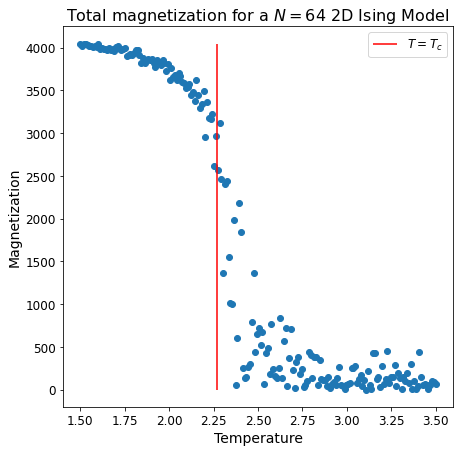

In [14]:
# simulation data
temps = np.linspace(1.5, 3.5, num=200)
mags = np.loadtxt('data/magnetization.dat')

# figure setup
plt.figure(figsize = (7, 7))
plt.title('Total magnetization for a $N=64$ 2D Ising Model')
plt.vlines(T_c, min(mags), max(mags), color='r', label='$T = T_c$')
plt.xlabel('Temperature')
plt.ylabel('Magnetization')
plt.scatter(temps, mags)
plt.legend()

## <span style="color:darkslateblue">Susceptibility and Specific Heat


### <span style="color:darkcyan">Exercise 4.11
Find a convenient formula to measure the susceptibility $\chi$ in a simulation.

$$
\chi = \frac 1T \left\langle (M - \langle M \rangle)^2 \right\rangle.
$$

### <span style="color:darkcyan">Exercise 4.12
Write a function that computes the energy of an Ising configuration.
    
It's been done already in exercise 4.8. If one wants to get the energy per spin, one can call `IsingModel::GetEnergy` and then divide by $N^2$.

### <span style="color:darkcyan">Exercise 4.13
We define a method `IsingModel::GetSpecificHeat` that computes the specific heat from the following equation
    
$$
C = \frac{1}{T^2} \left\langle (E - \langle E \rangle)^2 \right\rangle.
$$

We also define a method that computes the susceptibility `IsingModel::GetSusceptibility` using the formula from the previous exercise.

### <span style="color:darkcyan">Exercise 4.14
I compute $C$ and $\chi$ at different temperatures, for a small system of size $N=30$, after a period of $N_\text{eq}=100$ equilibration time.

In [15]:
# comment the following lines in order to avoid repeating the simulation
# current simulated data can be found in files data/susceptibility.dat
"""
temps = np.linspace(1.5, 3.5, num=200) # define range of temperatures
models = [IsingModel(N=30, T=temp, seed=10, N_eq=100, verbose=False) for temp in temps]
chis = [model.GetSusceptibility(100) for model in models]
heats = [model.GetSpecificHeat(100) for model in models]

# the following lines save data, so that one need not do the simulation again
np.savetxt('data/specific_heat.dat', heats)
np.savetxt('data/susceptibility.dat', chis)
"""

"\ntemps = np.linspace(1.5, 3.5, num=200) # define range of temperatures\nmodels = [IsingModel(N=30, T=temp, seed=10, N_eq=100, verbose=False) for temp in temps]\nchis = [model.GetSusceptibility(100) for model in models]\nheats = [model.GetSpecificHeat(100) for model in models]\n\n# the following lines save data, so that one need not do the simulation again\nnp.savetxt('data/specific_heat.dat', heats)\nnp.savetxt('data/susceptibility.dat', chis)\n"

Below I show the behavior of $\chi$ and $C$ as a function of $T$. The critical temperature $T_c$ is marked with a red vertical line.

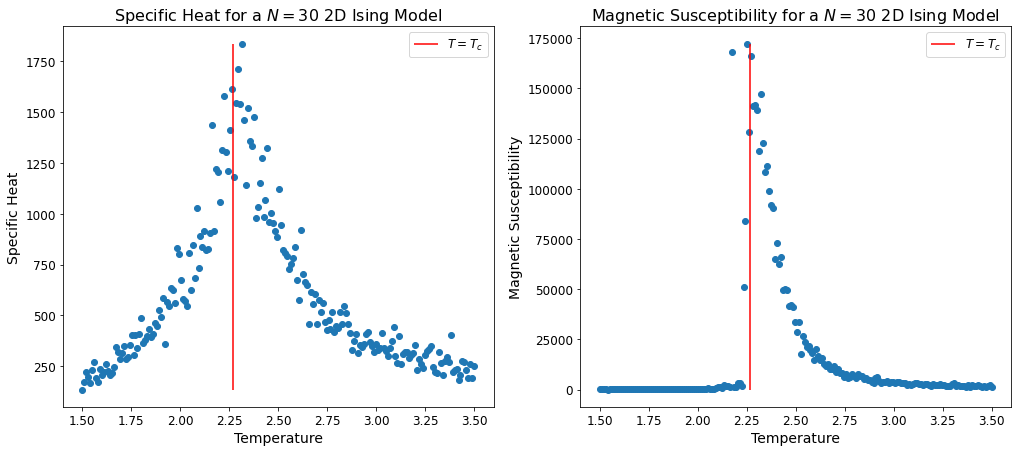

In [16]:
# simulation data
temps = np.linspace(1.5, 3.5, num=200)
heats = np.loadtxt('data/specific_heat.dat')
chis = np.loadtxt('data/susceptibility.dat')
data = [heats, chis]

# figure setup
fig, axs = plt.subplots(1, 2, figsize=(17, 7))
titles = ['Specific Heat', 'Magnetic Susceptibility']
for dat, title, ax in zip(data, titles, axs):
    ax.vlines(T_c, min(dat), max(dat), color='r', label='$T = T_c$')
    ax.set_title(title + ' for a $N=30$ 2D Ising Model')
    ax.set_xlabel('Temperature')
    ax.set_ylabel(title)
    ax.scatter(temps, dat)
    ax.legend()

### <span style="color:darkcyan">Exercise 4.15
Discuss whether or not your results proof the existence of a phase transition.

I can clearly see that the magnetic susceptibility and the specific heat show a non-differentiable behavior at $T=T_c$. This indicates that there is a phase transition of the second order.

## <span style="color:darkslateblue">Finding clusters
Given an Ising configuration, we define a cluster of spins as a set of neighbouring spins of the same sign surrounded by spins of the opposite sign.

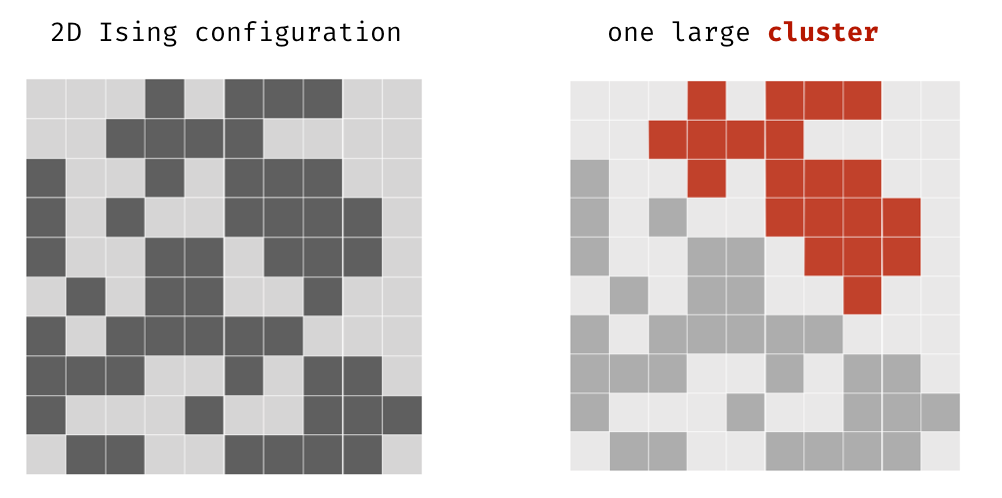

### <span style="color:darkcyan">Exercise 4.16
An efficient way to find all cluster for a given spin configuration is to use recursive functions. We define an external function called `cluster_measures` that returns both the labels matrix and a list of sizes of cluster, to be used in exercise 4.18.

```Python
def cluster_measures(config):
    setup N and labels matrix all zeros
    set first label to 1
    #
    for every row:
        for every column:
            call iterative function `recursive_size` to get the size of cluster number `label`
            if size is not zero:
                increase label
                save size of cluster
    #
    return labels matrix and cluster distribution
    note that labels matrix is modified in place by the iterative function `recursive_size`
```
    
The recursive function should return the size of a certain labelled cluster and modify labels matrix in place, as follows.
    
```Python
def recursive_size(config, labels, newlabel, x, y):
    start from a point in the x-th row and y-th column
    if it already has a label:
        return 0 (no need to check size of this cluster since 
        it has already been checked)
    else
        no label yet, meaning that a new cluster will be defined
        by the spin in the x-th row and y-th column and all its
        NNs with same spin, and all their NNs with same spin, and so on...
    #
    s = spin of x-th row and y-th column
    label matrix is modified: new label for this spin
    size of cluster is minimum 1
    #
    check for upper and lower NNs follows
    if we are on the lower edge:
        NN is on the upper edge at same column
        if this NN has same spin:
            increase size by calling 'recursive_size' again for
            the spin in the 0-th row and y-th column
        else do nothing
    else (meaning we are not on the lower edge):
        do the check for the lower NN
    then do the check the same way for the upper NN
    note that there is no need to check if x-1th row exists because
    if x-1 = -1 python already takes the final row
    #
    do the same check for right and left NNs
    #
    return the size of cluster
```

There might be the need to increase the maximum number of allowed recursion, by using `sys.setrecursionlimit()` as I did in the first cell.

### <span style="color:darkcyan">Exercise 4.17
We define a function that, given a configuration array `config`, returns another array `labels` where each cluster has a different label. We also account for periodic boundary conditions.

In [33]:
def recursive_size(config, labels, newlabel, x, y):
    if(labels[x][y] != 0):
        return 0
    #
    S = config[x][y]
    labels[x][y] = newlabel
    size = 1
    #
    if(x+1 == config.shape[0]):
        if(config[0][y] == S):
            size += recursive_size(config,labels, newlabel, 0, y)
    else:
        if(config[x+1][y] == S):
            size += recursive_size(config, labels, newlabel, x+1, y)
    if(config[x-1][y] == S):
        size += recursive_size(config,labels,newlabel,(x-1)%config.shape[0], y)
    #
    if(y+1 == config.shape[1]):
        if(config[x][0] == S):
            size += recursive_size(config,labels, newlabel, x, 0)
    else:
        if(config[x][y+1] == S):
            size += recursive_size(config, labels, newlabel, x, y+1)
    if(config[x][y-1] == S):
        size += recursive_size(config,labels,newlabel,x, (y-1)%config.shape[1])
    #
    return size

def cluster_measures(config):
    N = len(config)
    labels = np.zeros((N,N), int)
    sizes = []
    label = 1
    #
    for i in range(N):
        for j in range(N):
            size = recursive_size(config, labels, label, i, j)
            if(size != 0):
                label += 1
                sizes += [size]
    #
    return labels, sizes

Below I test the method for different system sizes. Note that, since I do not thermalize the systems, it is completely insignificant to set a particular temperature.

CPU times: user 801 ms, sys: 1 µs, total: 801 ms
Wall time: 801 ms


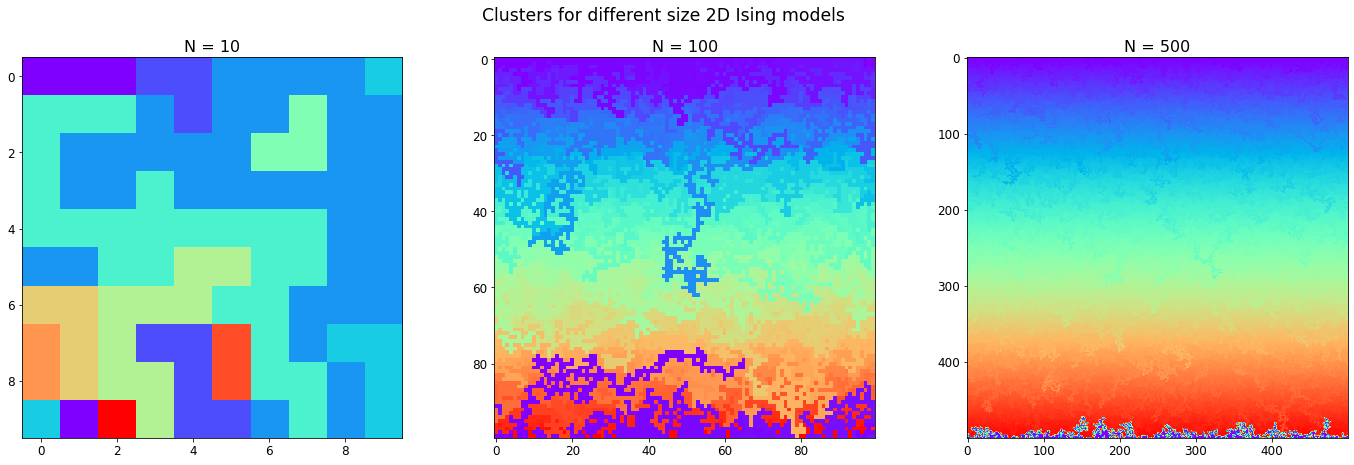

In [25]:
%%time
fig, axs = plt.subplots(1, 3, figsize=(24, 7))
fig.suptitle('Clusters for different size 2D Ising models', fontsize = 'xx-large')
dims = [10, 100, 500]
models = [myIsing(N=dim) for dim in dims]
for dim, model, ax in zip(dims, models, axs):
    ax.set_title('N = ' + str(dim))
    ax.imshow(get_labels(model.lattice)[0], cmap='rainbow')

### <span style="color:darkcyan">Exercise 4.18
Find an efficient way to measure cluster sizes.
    
Given a certain labels matrix, one can define the following function

```Python
def get_sizes(labels):
    _count = Counter()
    N = len(labels)
    labels_ar = labels.reshape((N**2,))
    _count.update(labels_ar)
    sizes = [_count[i+1] for i in range(int(max(labels_ar)))]
    return sizes
```
    
However, my function `cluster_measures` already returns a tuple with the size distribution, so there is no need for this function. Note that the efficiency is improved by this choice, since there is no need to reshape arrays and count again.

### <span style="color:darkcyan">Exercise 4.19
For $T >> T_c$, spins are essentially uncorrelated. What is the distribution of cluster sizes you expect to find in this case? **Hint** Think about the 1D case assuming totally uncorrelated spins.

*Your answer here*



### <span style="color:darkcyan">Exercice 4.20
Do a simulation at very high temperature and measure the cluster size distribution. Plot your results in log-log scale. Do your results agree with your previous answer?

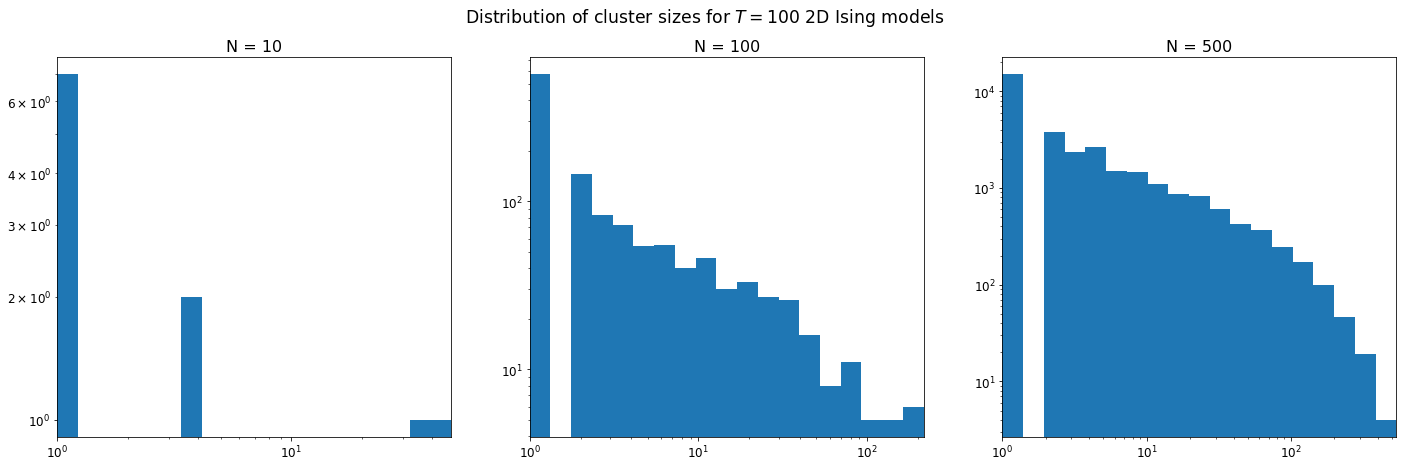

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(24, 7))
fig.suptitle('Distribution of cluster sizes for $T=100$ 2D Ising models', fontsize = 'xx-large')
dims = [10, 100, 500]
models = [IsingModel(N=dim, T=100, N_eq=10, verbose=False) for dim in dims]
sizes = [get_labels(model.lattice)[1] for model in models]
for dim, size, ax in zip(dims, sizes, axs):
    bins = np.geomspace(min(size), max(size), num=20)
    ax.set_title('N = ' + str(dim))
    ax.hist(size, bins=bins)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(min(size), max(size))

### <span style="color:darkcyan">Exercise 4.21

At $T_c$, the distribution of cluster sizes is known to be a power law with exponent close to $\alpha \simeq 2$.

$$
P(s) \propto s^{-\alpha}
$$

Do a simulation at $T=T_c$ and compare the resulting cluster size distribution with that obtained at $T>>T_c$.

AttributeError: 'tuple' object has no attribute 'reshape'

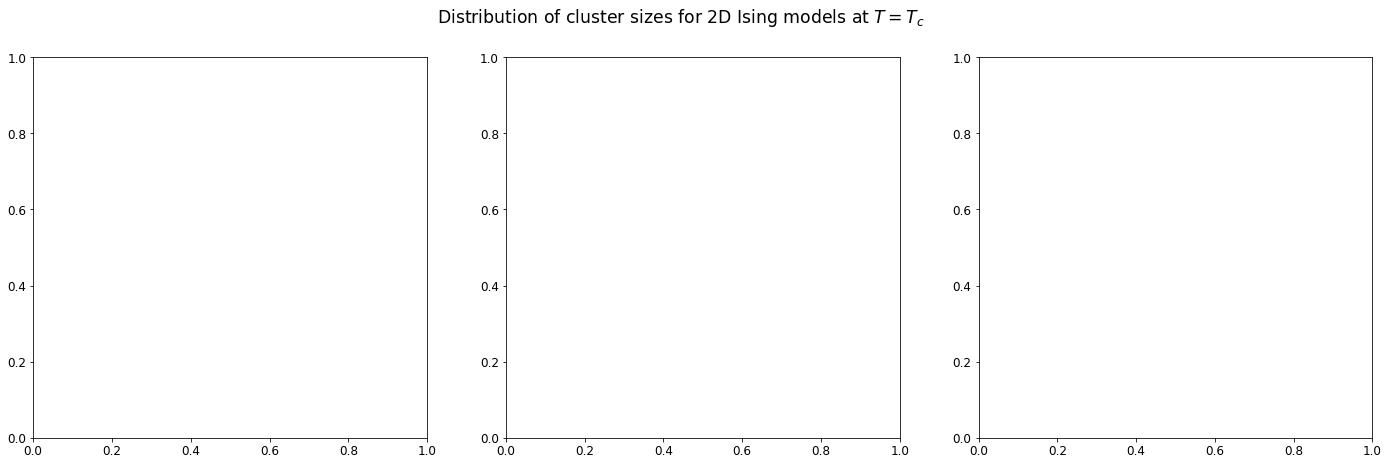

In [35]:
f = lambda x, k, m: m * x**(-k)
fig, axs = plt.subplots(1, 3, figsize=(24, 7))
fig.suptitle('Distribution of cluster sizes for 2D Ising models at $T=T_c$', fontsize = 'xx-large')
dims = [50, 100, 500]
models = [myIsing(N=dim) for dim in dims]
sizes = [get_sizes(get_labels(model.lattice)) for model in models]
for dim, size, ax in zip(dims, sizes, axs):
    bins = np.geomspace(min(size), max(size), num=20)
    x = np.arange(max(size))
    ax.set_title('N = ' + str(dim))
    ax.hist(size, bins=bins)
    popt, pcov = curve_fit(f, size)
    k = popt[0]
    m = popt[1]
    ax.plot(x, f(x,k,m), label = f'k = {k:.4f}\nm = {m:.4f}', c = 'red') # plot fit
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(min(size), max(size))